# Block rewards

In [15]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

R header:

In [16]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(size=17)
                # text=element_text(family="Arial")
                ) 


Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [17]:
# remove.packages("ptdalgorithms")

In [18]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [19]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [20]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [21]:
# Rcpp::sourceCpp("./cpp/timeinhom-kingman.cpp")

# Plotting

In [22]:
source("plot_functions.R")

In [23]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

In [24]:
plot_sfs <- function(graph, rewards) {
    sfs <- apply(rewards, 1, function(x) expectation(graph, x))
    data.frame(
      ton=seq(1,length(sfs)),  
      brlen=sfs
      ) %>% ggplot(aes(x=ton, y=brlen, fill=ton)) + 
      geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + 
          scale_x_continuous(breaks = 1:(dim(rewards)[1])) +
          theme(legend.position = "none") + labs(x='nr descendants') +
          labs(y = "Total branch length", x = "Number of descendants") +
          despine
}
                 
get_cov_mat <- function(graph, rewards) {
    n <- nrow(rewards)
    cov_mat <- matrix(nrow=n,ncol=n)
    for (i in 1:(n)) {
        for (j in 1:(n)) {
            cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
        }
    }
    return(cov_mat)
}
                  
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    df$ton1 <- as.character(df$ton1)
    df$ton2 <- gsub("V","",as.character(df$ton2))
    df$ton1 <- factor(df$ton1, levels=unique(df$ton1[order(as.numeric(df$ton1))]))
    df$ton2 <- factor(df$ton2, levels=unique(df$ton2[order(as.numeric(df$ton2))]))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}

# Coalescent

In [25]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- rep(0, n)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)  
        
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

# Block coalescent and rewards derived from full graph

In [26]:
state_mapping_callback <- function(state) {
    block_state <- c(sum(state))
    return(block_state)
}

rate_mapping_callback <- function(state, child_state) {
    rate <- state[1] * (state[1] - 1) / 2
    return(rate)
}

n <- 6
graph <- standard_coalescent(n) 
state_vector_length <- n

reward_list <- list()

block_state_vector_length <- 1
block_graph <- create_graph(block_state_vector_length)

for (i in 1:vertices_length(graph)) {

    vertex <- vertex_at(graph, i)
    state <- vertex$state

    if (i == 1) {
        block_vertex <- vertex_at(block_graph, 1)
    } else {
        block_state <- state_mapping_callback(state)
        block_vertex <- find_or_create_vertex(block_graph, block_state)
    }

    for (edge in edges(vertex)) {
        child_state <- edge$child$state
        block_child_state <- state_mapping_callback(child_state)
        block_child_vertex <- find_or_create_vertex(block_graph, block_child_state)

        added_reward <- edge$weight * child_state
        reward_list[[block_child_vertex$index]] <- tryCatch(reward_list[[block_child_vertex$index]], error=function(e) {0}) + added_reward

        is_child <- FALSE
        for (block_edge in edges(block_vertex)) {

            if (block_edge$child$index == block_child_vertex$index) {
                is_child <- TRUE
                break
            }
        }
        if (is_child) {
            next
        }
        
        if (i == 1)
            block_rate <- 1
        else
            block_rate <- rate_mapping_callback(block_state, block_child_state)

        add_edge(
          block_vertex,
          block_child_vertex,
          block_rate
          # edge$weight
        )

    }
}
#reward_list[[1]] <- rep(0, state_vector_length)

#reward_list

reward_matrix <- do.call(cbind, reward_list)
reward_matrix <- t(t(reward_matrix)/colSums(reward_matrix)*n:1)

reward_matrix <- cbind(rep(0, nrow(reward_matrix)), reward_matrix)
#reward_matrix <- rbind(rep(0, ncol(reward_matrix)), reward_matrix)

reward_matrix

0,6,4,2.4,1.2500000,0.3333333,0
0,0,1,1.2,0.8333333,0.5555556,0
0,0,0,0.4,0.5833333,0.2222222,0
0,0,0,0.0,0.3333333,0.5555556,0
0,0,0,0.0,0.0000000,0.3333333,0
0,0,0,0.0,0.0000000,0.0000000,1


In [27]:
apply(reward_matrix, 1, function(x) expectation(block_graph, x))

[1] 1.9500000 1.1333333 0.4833333 0.6666667 0.3333333 0.0000000

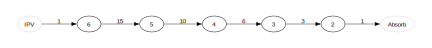

In [28]:
plot_graph(graph_as_matrix(block_graph), fontsize=14, ranksep=1, nodesep=0.25)

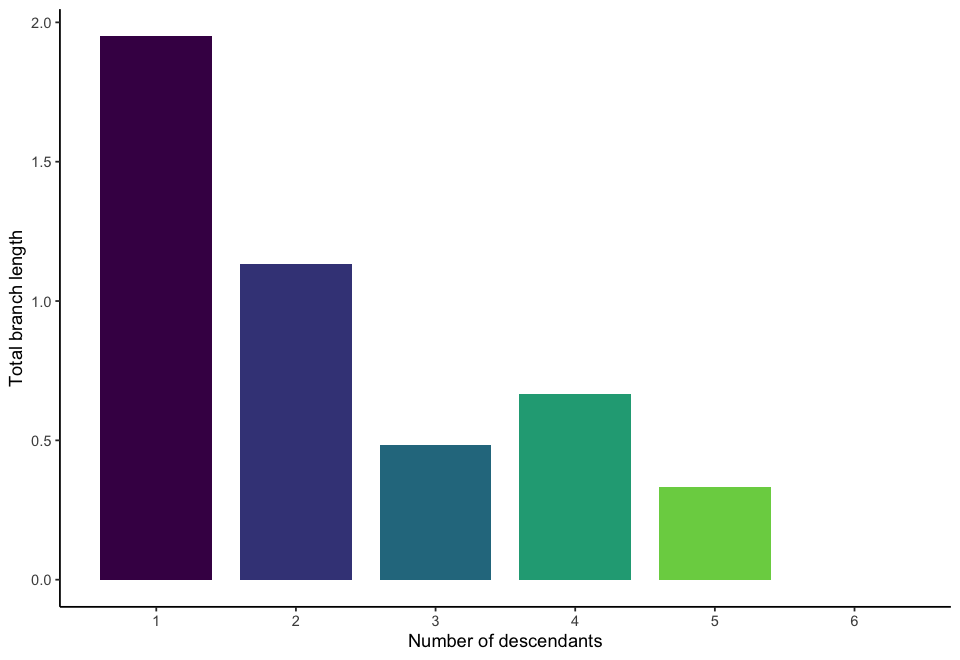

In [29]:
plot_sfs(block_graph, reward_matrix) 

## Same in Cpp

In [42]:
Rcpp::sourceCpp("./cpp/reward_zip.cpp")

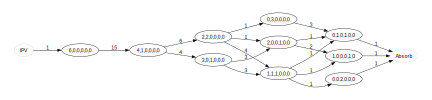

In [43]:
n <- 6
graph <- standard_coalescent(n)
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

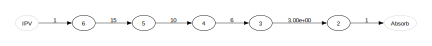

In [44]:
callback <- function(x) {
    return(sum(x))
}
zipped <- reward_zip(graph, callback)
plot_graph(graph_as_matrix(zipped$graph), fontsize=14, ranksep=1, nodesep=0.25)

In [45]:
zipped$rewards

0,6,4,2.4,1.2,0.4,0
0,0,1,1.2,0.9,0.4,0
0,0,0,0.4,0.6,0.4,0
0,0,0,0.0,0.3,0.4,0
0,0,0,0.0,0.0,0.4,0
0,0,0,0.0,0.0,0.0,1


In [46]:
apply(zipped$rewards, 1, function(x) expectation(zipped$graph, x))

[1] 2.0000000 1.0000000 0.6666667 0.5000000 0.4000000 0.0000000

## I guess I need to keep track of the probability of reaching each vertex and scale weights and rewards with that

## but how would that work with cyclic graphs...?

## maye I can only do it on the acylic ones...?

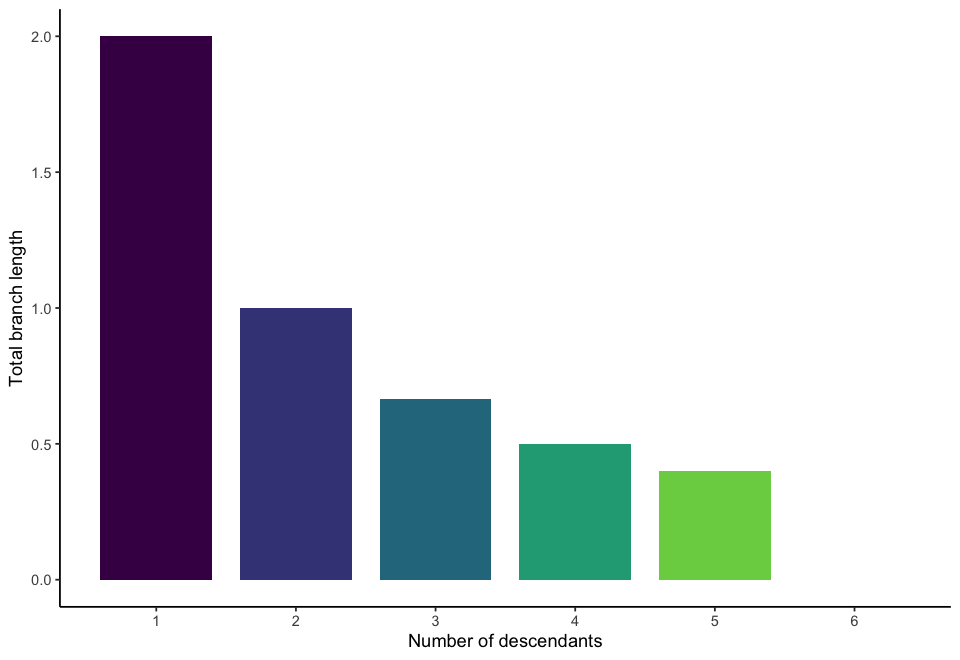

In [49]:
plot_sfs(zipped$graph, zipped$rewards) 


# Block coalescent

In [126]:
block_coalescent <- function(n) {
      
    state_vector_length <- 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(0)
    initial_state[1] <- n
    add_edge(starting_vertex, create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {

      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] == 1) {
        break
      }
      rate <- state[1] * (state[1] - 1) / 2
      child_state <- state
      child_state[1] <- child_state[1] - 1
      add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
      index <- index + 1
    }
    return(graph)
}

In [127]:
n <- 4
graph <- block_coalescent(n)
gam <- graph_as_matrix(graph)

In [128]:
gam

$states
     [,1]
[1,]    4
[2,]    3
[3,]    2

$SIM
     [,1] [,2] [,3]
[1,]   -6    6    0
[2,]    0   -3    3
[3,]    0    0   -1

$IPV
[1] 1 0 0

$indices
[1] 2 3 4

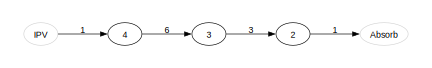

In [129]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

## SFS rewards for block coalescent

In [130]:
install.packages("partitions")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [145]:
library("partitions")

# equivalence_classes <- function(n) {
#     p <- parts(n)
#     return(apply(p, 2, function(x) {x[x!=0]}))
# }

equivalence_classes <- function(n, size=0) {
    if (size != 0) {    
        m <- apply(parts(n), 2, function(x) {x[x!=0]})
        p <- m[lapply(m, length) == size]
    } else {
        p <- apply(parts(n), 2, function(x) {x[x!=0]})
    }
    return(p)
}

ton_counts <- function(p, n) {
    result <- rep(0, n)
    counts <- table(p)
    for (i in seq(n)) {
        c <- counts[names(counts)==i]
        if (length(c)) {
            result[i] <- c
        }
    }
    return(result)
}

multinom <- function(params) {
    if (length(params) == 1) {
        return(1)
    }
    return(choose(sum(params), params[length(params)]) * multinom(params[-length(params)]))
}

In [146]:
# coalescent_reward_matrix <- function(n) {
#     rewards <- matrix(0, n, n)
#     for (p in equivalence_classes(n)) {
#         counts <- ton_counts(p, n)
#         rewards[length(p), ] <- rewards[length(p), ] + counts * multinom(counts)
#     }
#     rewards <- rewards[-1, -ncol(rewards)]
#     if (n == 2) {
#         stopifnot(0, "NOT IMPLEMENTED")
#         scale <- 2/sum(rewards)
#         rewards <- rewards * scale
#         rewards <- c(0, rewards, 0)
#     } else {
#         scale <- (2:n)/apply(rewards, 1, sum)
#         rewards <- rewards * scale
#         rewards <- t(rewards)[, ncol(rewards):1]
#         rewards <- cbind(rep(0, nrow(rewards)), rewards, rep(0, nrow(rewards)))
#     }
#     return(rewards)        
# }
# rewards <- coalescent_reward_matrix(5)
# print(rewards)
# expectation(graph, rewards[3, ])

In [147]:
get_block_rewards <- function(n, l) {
    # a column in the matrix computed by get_block_rewards
    rewards <- matrix(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        rewards = rewards + counts * multinom(counts)
    }

    rewards <- rewards[-length(rewards)]
    if (sum(rewards) > 0) {
        scale <- l/sum(rewards)
        rewards <- rewards * scale
    }
    rewards <- c(0, rewards)
    return(matrix(rewards))
}
get_block_rewards(5, 3)

0.0
1.5
1.0
0.5
0.0


In [148]:
tensor_dims <- c(n, vertices_length(graph))
reward_fun <- get_block_rewards

reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
rewards

0,0,0,0.0000000,0
0,4,2,0.6666667,0
0,0,1,0.6666667,0
0,0,0,0.6666667,0


In [19]:
expectation(graph, rewards[4, ])

[1] 0.6666667

## Precompute and cache as HDF5

Precompute rewards for a range of sample sizes:

In [23]:
# to_delete <- c()#70:80
# if (length(to_delete) > 0) {
#     h5f <- H5Fopen("../coal_block_rewards.h5")
#     for (sample_size in to_delete) {
#         name <- paste("coalescent/", sample_size, sep="")
#         if (H5Lexists(h5f, name)) {
#             h5delete(h5f, name=name)                          
#         }
#     }
#     H5Fclose(h5f)
# }

In [ ]:
reward_fun <- get_block_rewards

coal_block_rewards_h5_file <- "../coal_block_rewards.h5"
if (!file.exists(coal_block_rewards_h5_file)) {
    h5createFile(coal_block_rewards_h5_file)
    h5createGroup(coal_block_rewards_h5_file, "coalescent")
}
h5f <- H5Fopen(coal_block_rewards_file)
for (sample_size in 50:100) {
    name <- paste("coalescent/", sample_size, sep="")
    if (H5Lexists(h5f, name)) {
        next
    }
    graph <- block_coalescent(sample_size)
    tensor_dims <- c(sample_size, vertices_length(graph))    
    reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(sample_size, vertex_at(graph, i)$state))))
    rewards <- array(unlist(reward_list), dim=tensor_dims)
    # h5delete(h5f, name = paste("coalescent/", sample_size, sep=""))                          
    h5write(rewards, h5f,
            # file="block_coal_rewards.h5", 
            name=paste("coalescent/", sample_size, sep=""))
    # print(sample_size)
    # flush.console()
}
H5Fclose(h5f)
#h5closeAll()

In [ ]:
rewards <- h5read("../coal_block_rewards.h5", name=paste("coalescent/", sample_size, sep=""))
sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
                         

## Cached computation of SFS

In [339]:
# library(parallel)

# redo_sfs_rewards <- TRUE

# if (redo_sfs_rewards) {
#     v <- 3:20
#     n_list <- as.list(v)
#     names(n_list) <- v
#     sfs_rewards <- mclapply(n_list, coalescent_reward_matrix, mc.cores=detectCores())
#     saveRDS(sfs_rewards, file="sfs_rewards.RData")
# } else {
#     sfs_rewards <- readRDS(file="sfs_rewards.RData")
# }
# rewards <- sfs_rewards[[as.character(n)]]
# sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
# sfs_expectation

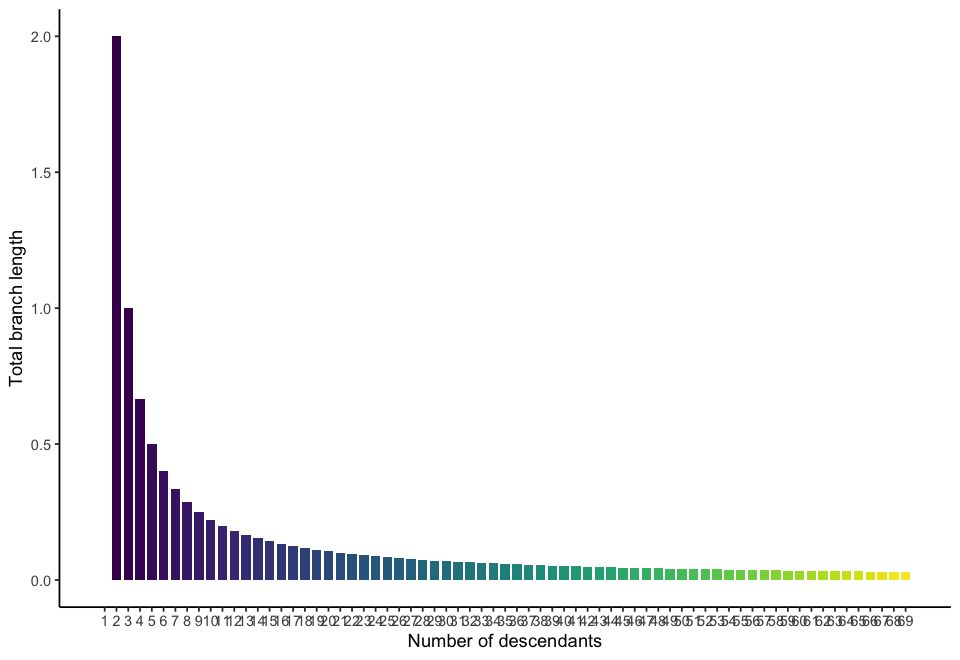

In [20]:
sfs_rewards <- function(graph, sample_size) {
    name <- paste("coalescent/", sample_size, sep="")
    h5f <- H5Fopen("../data/coal_block_rewards.h5")
    if (H5Lexists(h5f, name)) {
        rewards <- h5read(h5f, name=paste("coalescent/", sample_size, sep=""))
    } else {
        tensor_dims <- c(sample_size, vertices_length(graph))    
        reward_list <- lapply(1:vertices_length(graph), 
                              function(i) do.call(reward_fun, as.list(c(sample_size, vertex_at(graph, i)$state))))
        rewards <- array(unlist(reward_list), dim=tensor_dims)
        h5write(rewards, 
                h5f, 
                name=paste("coalescent/", sample_size, sep=""))
    }
    H5Fclose(h5f)                              
    return(rewards)
}

graph <- block_coalescent(69)
rewards <- sfs_rewards(graph, 69)
plot_sfs(graph, rewards)            

Compute the first moments for each "ton" for a number of samples:

In [22]:
nr_moments <- 10
sfs_moments <- data.frame(apply(rewards, 1, function(x) moments(graph, nr_moments, x)))
row.names(sfs_moments) <- 1:nr_moments
names(sfs_moments) <- 1:(sample_size-1)
sfs_moments

,1,2,3,4,5,6,7,8,9,10,⋯,41,42,43,44,45,46,47,48,49,NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,2.000000,1.000000,0.66666667,0.500000000,0.400000000,0.3333333333,2.857143e-01,2.500000e-01,2.222222e-01,⋯,5.000000e-02,4.878049e-02,4.761905e-02,4.651163e-02,4.545455e-02,4.444444e-02,4.347826e-02,4.255319e-02,4.166667e-02,4.081633e-02
2,0,4.081633,1.027494,0.46111352,0.262032476,0.169458713,0.1189337618,8.832421e-02,6.836348e-02,5.461423e-02,⋯,4.226279e-03,4.092830e-03,3.969561e-03,3.855632e-03,3.750297e-03,3.652898e-03,3.562851e-03,3.479640e-03,3.402807e-03,3.331945e-03
3,0,8.496460,1.084184,0.33062660,0.143757855,0.075907525,0.0453219777,2.945690e-02,2.037349e-02,1.477712e-02,⋯,5.208405e-04,5.034303e-04,4.875412e-04,4.730187e-04,4.597270e-04,4.475465e-04,4.363716e-04,4.261086e-04,4.166739e-04,4.079933e-04
4,0,18.033302,1.174205,0.24555749,0.082470205,0.035894403,0.0184061176,1.056952e-02,6.594050e-03,4.383002e-03,⋯,8.513741e-05,8.225443e-05,7.963364e-05,7.724592e-05,7.506608e-05,7.307226e-05,7.124541e-05,6.956895e-05,6.802840e-05,6.661115e-05
5,0,39.010818,1.304621,0.18876523,0.049416212,0.017890507,0.0079501967,4.069485e-03,2.310175e-03,1.419308e-03,⋯,1.737890e-05,1.678872e-05,1.625281e-05,1.576494e-05,1.531979e-05,1.491276e-05,1.453989e-05,1.419775e-05,1.388335e-05,1.359411e-05
6,0,85.983026,1.486329,0.15008071,0.030894816,0.009384973,0.0036450771,1.677055e-03,8.733174e-04,4.998269e-04,⋯,4.256236e-06,4.111609e-06,3.980316e-06,3.860817e-06,3.751791e-06,3.652107e-06,3.560790e-06,3.476999e-06,3.400004e-06,3.329170e-06
7,0,193.023121,1.735533,0.12332591,0.020132625,0.005174213,0.0017706619,7.379632e-04,3.551629e-04,1.907220e-04,⋯,1.216077e-06,1.174749e-06,1.137235e-06,1.103091e-06,1.071940e-06,1.043459e-06,1.017369e-06,9.934283e-07,9.714296e-07,9.511915e-07
8,0,441.195704,2.076075,0.10466804,0.013661101,0.002994106,0.0009096739,3.459428e-04,1.549414e-04,7.857818e-05,⋯,3.970869e-07,3.835919e-07,3.713420e-07,3.601930e-07,3.500213e-07,3.407213e-07,3.322020e-07,3.243848e-07,3.172015e-07,3.105931e-07
9,0,1026.455312,2.543065,0.09168929,0.009643381,0.001816084,0.0004934130,1.723864e-04,7.231147e-05,3.484044e-05,⋯,1.458687e-07,1.409113e-07,1.364114e-07,1.323158e-07,1.285793e-07,1.251629e-07,1.220334e-07,1.191617e-07,1.165230e-07,1.140954e-07


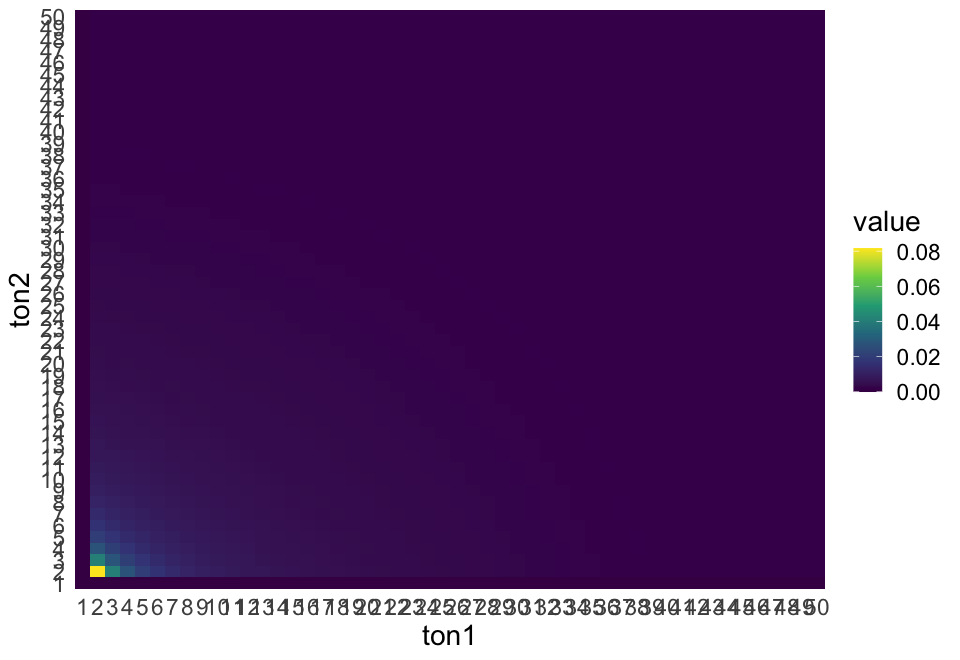

In [23]:
plot_cov_mat(get_cov_mat(graph, rewards))

# ARG

## Block ARG in R

In [76]:
block_arg <- function(n, rho=1) {
      
    state_vector_length <- 4
    # state_vector_length <- 3
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(n, n, n, 0)
    # initial_state <- c(n, n, n)
    add_edge(starting_vertex, find_or_create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state

        
      if (state[1] <= 1 && state[2] <= 1 && (state[3] == 1 ) ) {
      # if (state[1] <= 1 && state[2] <= 1) {
        index <- index + 1 
        next
      }

     # PROBLEM: WE KEEP TRACK OF HOW MANY THAT HAVE LINKED BACK TOGETHER, 
     # BUT NOT IF THESE HAVE LINKED APART AGAIN, SO WE DO NOT HAVE A WAY TO 
     # TO DETERMINE IF THE LAST TWO L1 AND L2 ARE LINKED OR NOT...
        # but we know from the ratio og coal rate and rec rate what proportion
        # of the time that they are...

        
      l1 <- state[1] - state[3]
      l2 <- state[2] - state[3]
      l1l2 <- state[3]
      l1_l2 <- state[4]
      # prop_sample_linked <- state[4] / n

      if (l1 >= 1) {
        if (l1 >= 2 || l1l2 >= 1) {
            rate <- (l1 * (l1 - 1) / 2) + l1*l1l2
            child_state <- state
            child_state[1] <- child_state[1] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }
      if (l2 >= 1) {
        if (l2 >= 2 || l1l2 >= 1) {
            rate <- (l2 * (l2 - 1) / 2) + l2*l1l2
            child_state <- state
            child_state[2] <- child_state[2] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }         
      if (l1-l1_l2 >= 1 && l2-l1_l2 >= 1) { # THE ONES ARE NEITHER LINKED OR RELINKED
        rate <- l1 * l2
        child_state <- state
        child_state[4] <- child_state[4] + 1
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)   
      }
      if (l1l2 >=2) {
        rate <- l1l2 * (l1l2 - 1) / 2
        child_state <- state
        child_state[1] <- child_state[1] - 1
        child_state[2] <- child_state[2] - 1
        child_state[3] <- child_state[3] - 1          
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }        

      # recombination
      if (l1l2 >=1) {        
        rate <- rho        # hardcoded recombination rate
        child_state <- state
        child_state[3] <- child_state[3] - 1
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }

      index <- index + 1 
    }
    return(graph)
}

n <- 2
graph <- block_arg(n, rho=5)
vertices_length(graph)

[1] 22

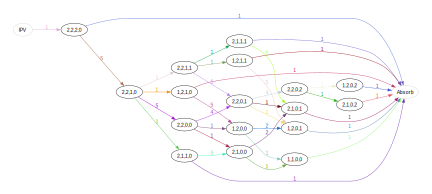

In [77]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

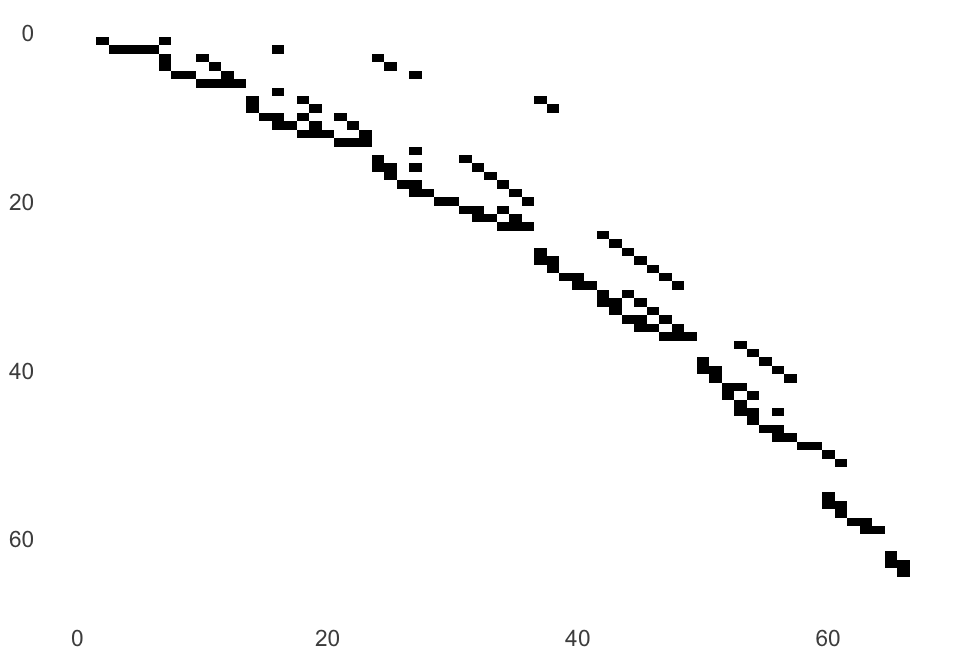

In [45]:
plot_sim <- function(graph)
{
    gam <- graph_as_matrix(graph)
    mat <- t(gam$SIM)
    mat <- matrix(as.integer(mat > 0), dim(mat))
    
    rownames(mat) <- 1:nrow(mat)
    colnames(mat) <- 1:ncol(mat)
    df <- as.data.frame(mat)
    df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
    df$n <- as.numeric(df$n)
    df$m <- as.numeric(df$m)
    ggplot(df, aes(n, m)) +
        geom_tile(aes(fill = value), show.legend = FALSE) + 
        scale_y_reverse() +
        scale_fill_gradient(low="white", high="black") +
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              text=element_text(size=17))
}

plot_sim(graph)

## 2D SFS rewards for block ARG

In [55]:
# get_block_rewards <- function(n, l) {
#     # a column in the matrix computed by get_block_rewards
#     rewards <- matrix(0, n)
#     for (p in equivalence_classes(n, size=l)) {
#         counts <- ton_counts(p, n)
#         rewards = rewards + counts * multinom(counts)
#     }

#     rewards <- rewards[-length(rewards)]
#     if (sum(rewards) > 0) {
#         scale <- l/sum(rewards)
#         rewards <- rewards * scale
#     }
#     rewards <- c(0, rewards)
#     return(matrix(rewards))
# }
# get_block_rewards(5, 3)

marg_tree_rewards <- function(n, l) {
    r <- rep(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        r <- r + counts * multinom(counts)
    }
    scale <- l / sum(r)
    r <- r * scale
    return(r)
}

          
# arg_state_reward <- function(n, locus1, locus2, linked, orig_linked) {
arg_state_reward <- function(n, locus1, locus2, linked, relinked) {

    l1 <- locus1 - linked
    l2 <- locus2 - linked

    rewards <- matrix(0, n+1, n+1)
    if (locus1 + locus2 == 0) {
        return(rewards)
    }
    part <- equivalence_classes(n, size=linked)
    print(part)
    for (l1_p in part) {
        for (l2_p in part) {
            for (a in l1_p) {
                for (b in l2_p) {
                    if (locus1 > 0)
                        rewards[a+1, b+1] <- rewards[a+1, b+1] + (1 - (linked / locus1)) * multinom(ton_counts(l1_p, n)) 
                    if (locus2 > 0)
                        rewards[a+1, b+1] <- rewards[a+1, b+1] + (1 - (linked / locus1)) * multinom(ton_counts(l2_p, n)) 

                        # (1 - orig_linked/n) * multinom(ton_counts(l1_p, n)) + 
                        # (1 - orig_linked/n) * multinom(ton_counts(l2_p, n)) 
                }
            }
        }
    }
    print(rewards)
    for (i in 1:length(part)) {
        p <- part[i][[1]]
        for (a in p) {
            if (locus1 > 0)
                rewards[a+1, a+1] <- rewards[a+1, a+1] + (linked / locus1) * multinom(ton_counts(p, n))
            if (locus2 > 0)
                rewards[a+1, a+1] <- rewards[a+1, a+1] + (linked / locus2) * multinom(ton_counts(p, n))

                # (orig_linked/n) * multinom(ton_counts(p, n)) + 
                # (orig_linked/n) * multinom(ton_counts(p, n)) 
        }
    }
#print(rewards)
    # top_row = colSums(rewards)
    # left_col = rowSums(rewards)
    
    rewards[n+1, n+1] = 0

    if (sum(rewards) > 0) {
        scale <- linked / sum(rewards)
        rewards <- rewards * scale
    }
    
    if (l1 > 0) {
        rewards[1, ] <- rewards[1, ] + c(0, marg_tree_rewards(n, l1) )
        # rewards[1, ] <- top_row
    }
    if (l2 > 0) {
        rewards[, 1] <- rewards[, 1] + c(0, marg_tree_rewards(n, l2) )
        # rewards[, 1] <- left_col
    }


    
    return(rewards)
}

# IT SEEMS WE DO NOT GET VALUES IN THE LINKED PART OF THE MATRIX IF NR LINKED IS ONE... 

# arg_state_reward(3, 3, 0, 0)
# #arg_state_reward(3, 3, 1, 0)

In [69]:
n = 4
graph <- block_arg(n, rho=5000)

tensor_dims <- c((n+1), (n+1), vertices_length(graph))
reward_fun <- arg_state_reward
reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
#print(dim(rewards))
expectation(graph, rewards[4, 4, ])

[[1]]
[1] 1 1 1 1

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    0    0
[2,]    0    0    0    0    0
[3,]    0    0    0    0    0
[4,]    0    0    0    0    0
[5,]    0    0    0    0    0
[[1]]
[1] 2 1 1

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    0    0
[2,]    0    0    0    0    0
[3,]    0    0    0    0    0
[4,]    0    0    0    0    0
[5,]    0    0    0    0    0
[[1]]
[1] 2 1 1

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0  0.0    0    0
[2,]    0    6  3.0    0    0
[3,]    0    3  1.5    0    0
[4,]    0    0  0.0    0    0
[5,]    0    0  0.0    0    0
[[1]]
[1] 3 1

[[2]]
[1] 2 2

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    0    0
[2,]    0    0    0    0    0
[3,]    0    0    0    0    0
[4,]    0    0    0    0    0
[5,]    0    0    0    0    0
[[1]]
[1] 3 1

[[2]]
[1] 2 2

     [,1]     [,2]     [,3]     [,4] [,5]
[1,]    0 0.000000 0.000000 0.000000    0
[2,]    0 1.333333 2.000000 1.333333    0
[3,]    0 2.000000 2.666667 2.000000    0

[1] 5.336755e-05

In [70]:
exp_mat <- matrix(0, nrow=n+1,ncol=n+1)
for (i in 1:(n+1)) {
  for (j in 1:(n+1)) {
    exp_mat[i,j] <- expectation(graph, rewards[i, j, ])
  }
} 
exp_mat

0.0000000,1.997337e+00,1.000331e+00,6.668002e-01,0.5559003
1.9973372,1.185665e-03,1.064734e-04,2.664637e-05,0.0000000
1.0003305,1.064734e-04,2.133901e-04,3.996956e-05,0.0000000
0.6668002,2.664637e-05,3.996956e-05,5.336755e-05,0.0000000
0.5559003,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000


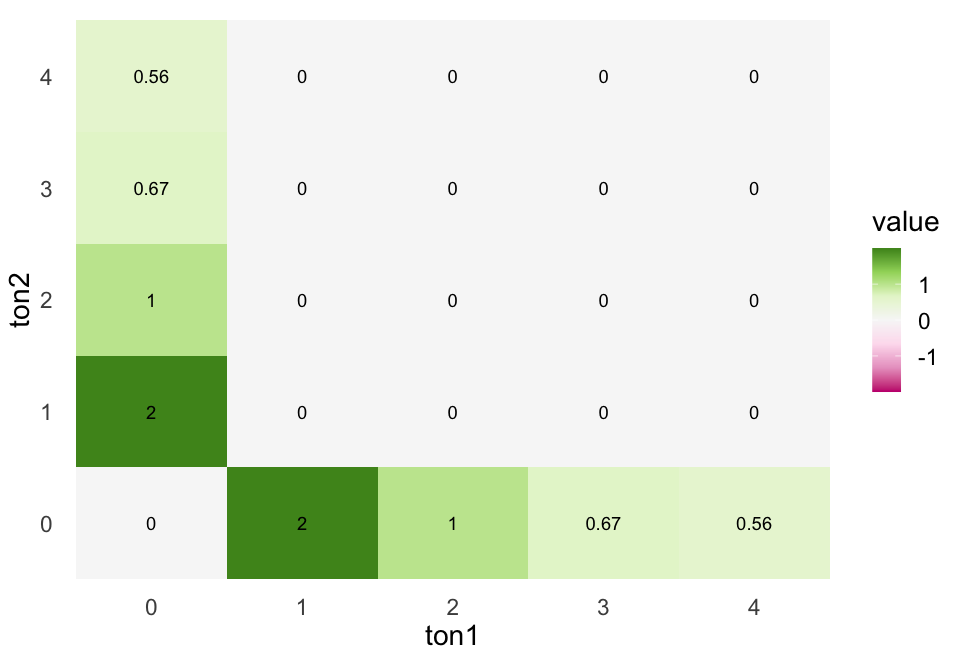

In [71]:
df <- as.data.frame(exp_mat) #%>% gather()
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
limit <- max(na.omit(abs(df$value))) * c(-1, 1)
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    geom_text(aes(label = round(value, 2))) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1, limit=limit) +
    theme_minimal() +
    theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

In [68]:
exp_mat[, 1] / sum(exp_mat[, 1])

[1] 0.0000000 0.2930616 0.2432806 0.2030296 0.2606282

In [516]:
exp_mat[1, ] / exp_mat[, 1]

[1] NaN   1   1   1   1   1

Marginal SFSs:

In [36]:
x <- colSums(exp_mat)
sfs_locus1 <- x[c(-1, -length(x))]
x <- rowSums(exp_mat)
sfs_locus2 <- x[c(-1, -length(x))]

Fits expectations for a single locus:

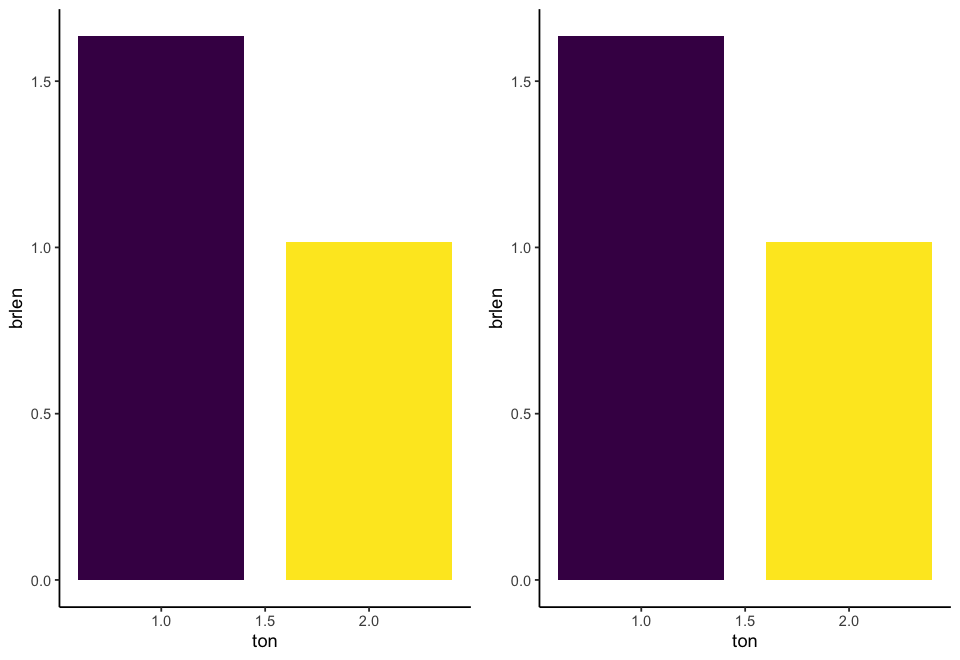

In [37]:
grid.arrange(
    data.frame(
      ton=seq(1,length(sfs_locus1)),  
      brlen=sfs_locus1
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    data.frame(
      ton=seq(1,length(sfs_locus2)),  
      brlen=sfs_locus2
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    nrow = 1)
